# Visualize tip data from model data frames

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

sns.set_style("ticks")

In [2]:
# Configure matplotlib theme.
fontsize = 14
matplotlib_params = {
    'axes.labelsize': fontsize,
    'font.size': fontsize,
    'legend.fontsize': 12,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'text.usetex': False,
    'figure.figsize': [6, 4],
    'savefig.dpi': 300,
    'figure.dpi': 120,
    'text.usetex': False
}

plt.rcParams.update(matplotlib_params)

# Turn off spines for all plots.
plt.rc("axes.spines", top=False, right=False)

In [3]:
delta_t = 1.0

In [4]:
# Read model data frame.
df = pd.read_table("model_inputs.tsv")

In [5]:
df.head()

,censored_frequency,clade_name,future_frequency,name,num_date,observed_frequency,predictor:ep_x,timepoint
0,0.019079,NODE_0001478,0.0,A/Beijing/XICHENG1272/2006,2006.944559,0.009248,-0.002225,2007.25
1,0.023808,NODE_0001478,0.0,A/HongKong/CUHK69904/2006,2006.993840,0.011540,-0.002225,2007.25
2,0.024944,NODE_0000205,0.0,A/Taiwan/70002/2007-egg,2007.005476,0.012091,-0.002225,2007.25
3,0.033049,NODE_0000205,0.0,A/Taiwan/70307/2007-egg,2007.093087,0.016020,-0.002225,2007.25
4,0.019196,NODE_0000205,0.0,A/Hanoi/BM38/2007-egg,2007.109514,0.008235,-0.002225,2007.25


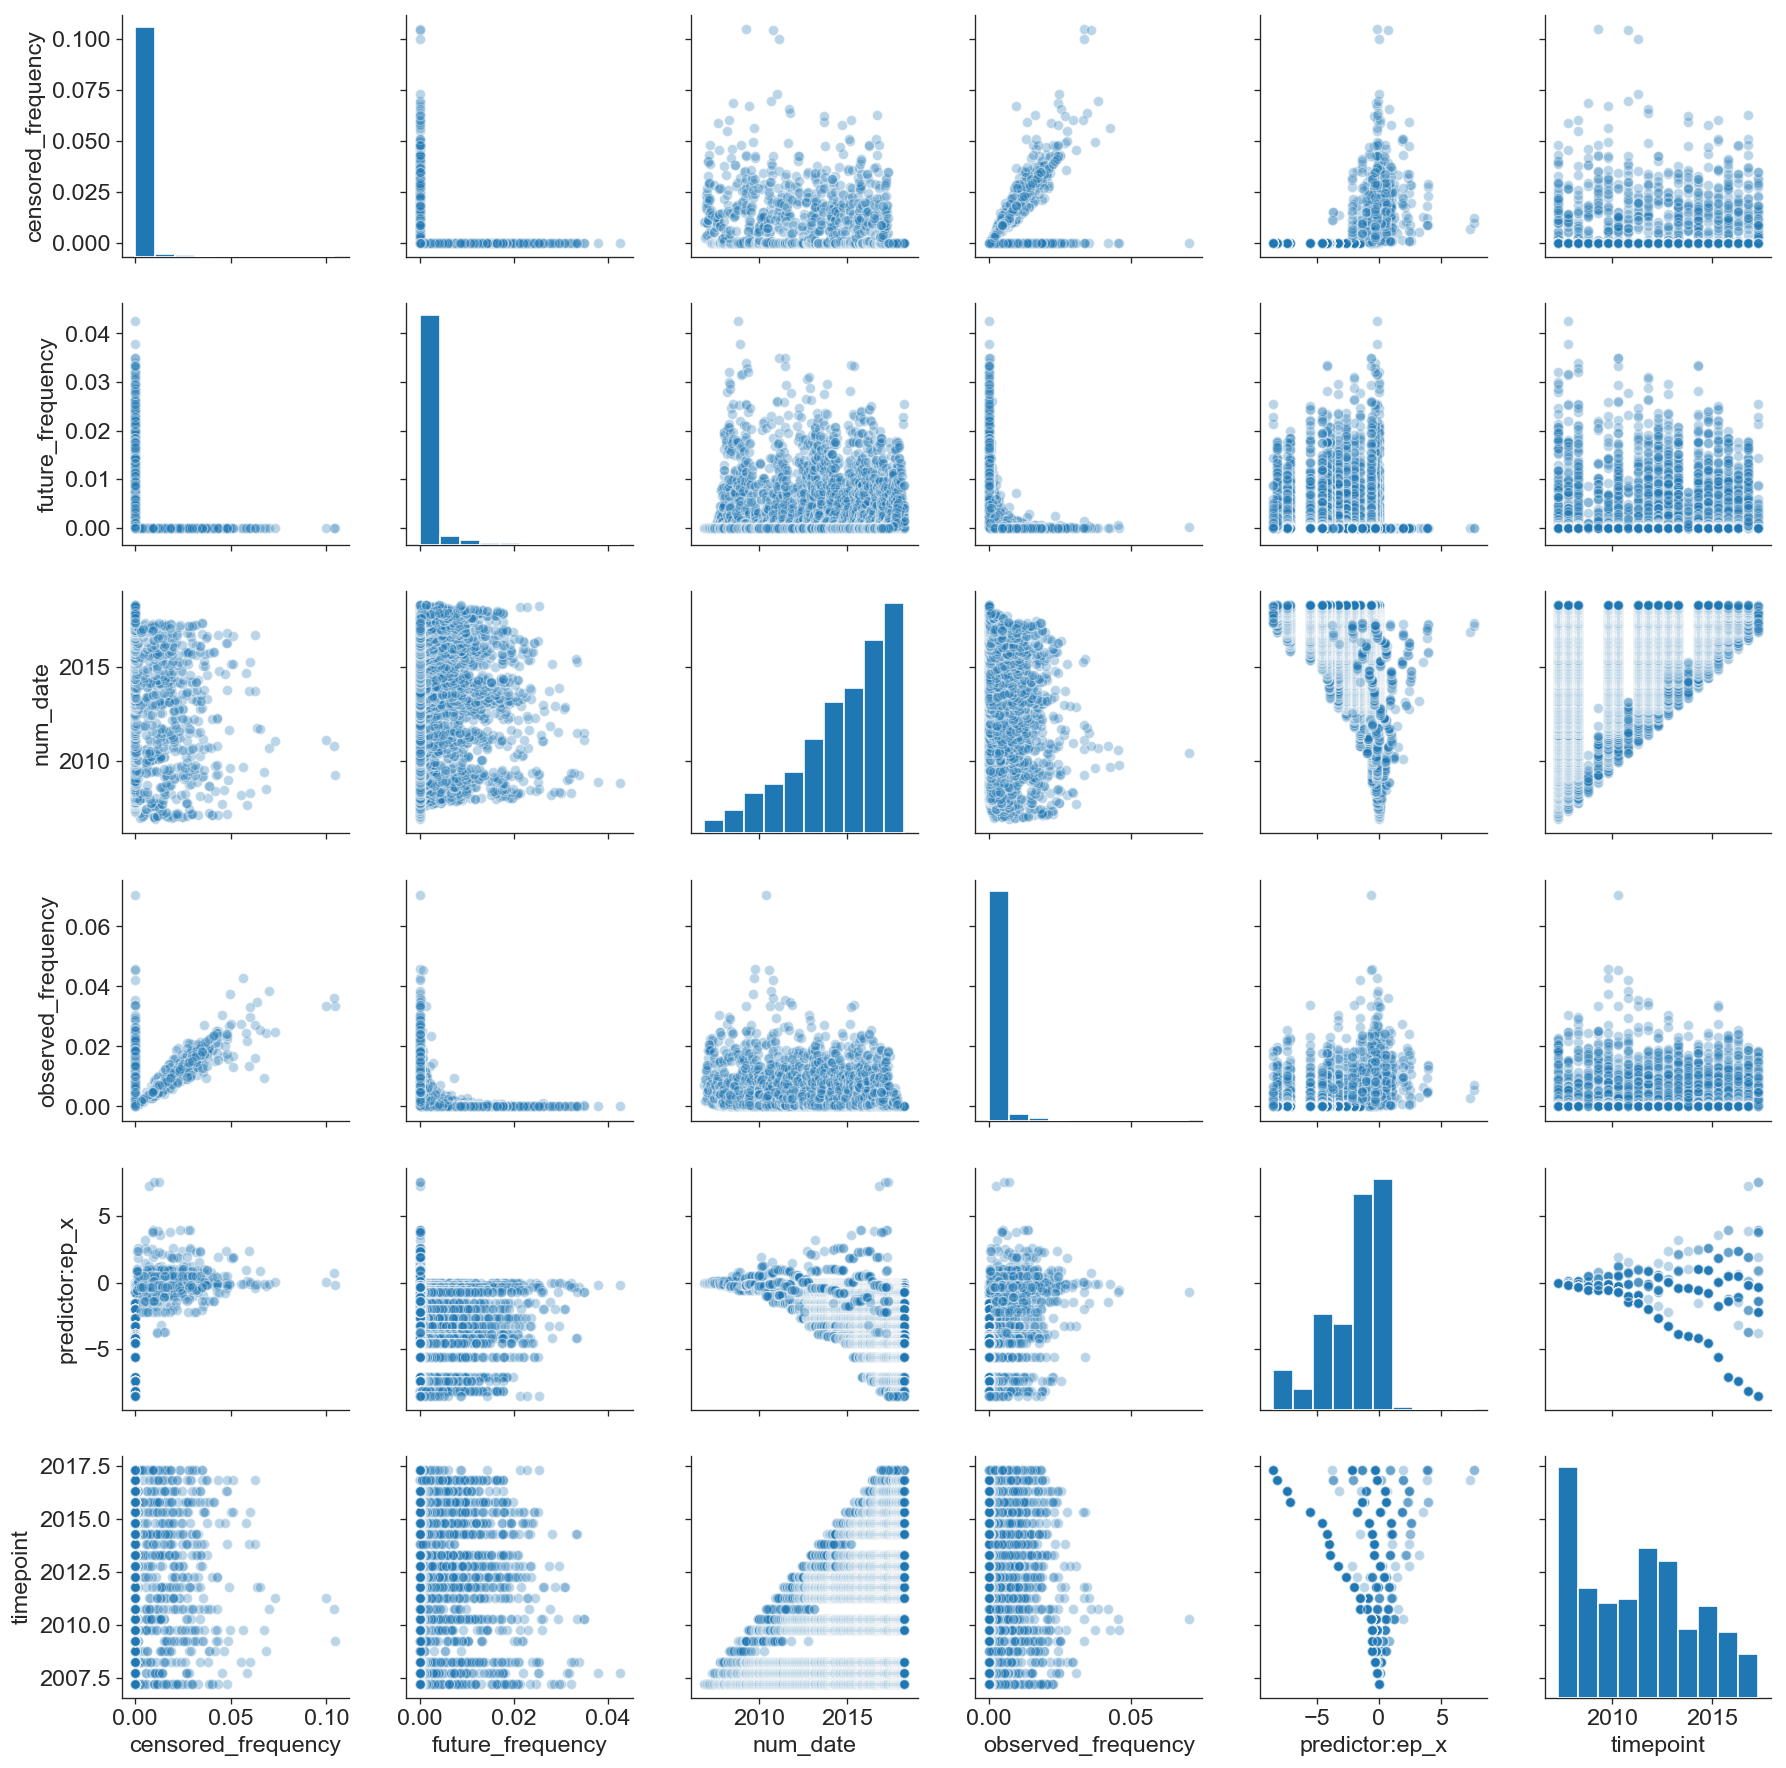

In [6]:
sns.pairplot(df, plot_kws={"alpha": 0.3})

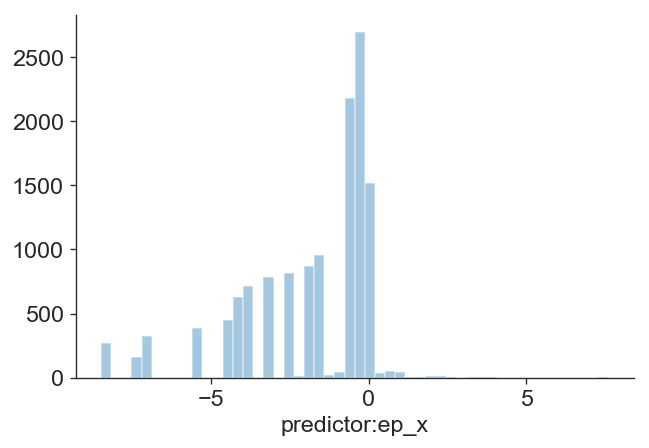

In [7]:
sns.distplot(df["predictor:ep_x"], kde=False)

In [8]:
#g = sns.FacetGrid(df[df["observed_frequency"] > 0], col="timepoint", col_wrap=4, sharey=False)
#g.map(sns.distplot, "predictor:ep_x", kde=False, bins=10)

## Plot the sampling density of tips by time

In [23]:
tips = df.loc[:, ["name", "num_date"]].drop_duplicates()

In [24]:
tips.head()

,name,num_date
0,A/Beijing/XICHENG1272/2006,2006.944559
1,A/HongKong/CUHK69904/2006,2006.993840
2,A/Taiwan/70002/2007-egg,2007.005476
3,A/Taiwan/70307/2007-egg,2007.093087
4,A/Hanoi/BM38/2007-egg,2007.109514


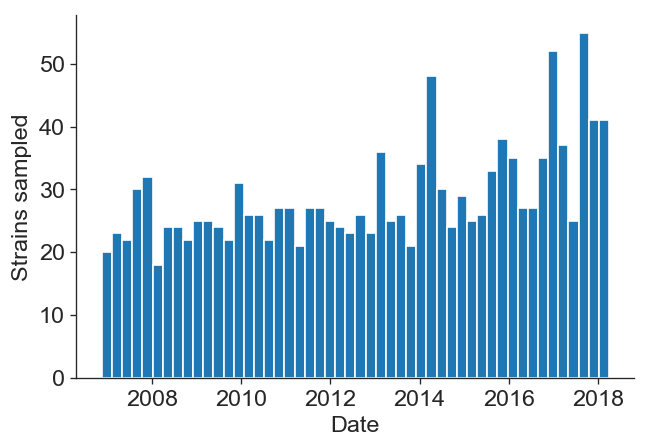

In [28]:
plt.hist(tips["num_date"], bins=50)
plt.xlabel("Date")
plt.ylabel("Strains sampled")

## Reconstruct observed clade frequencies from tips

In [9]:
clade_frequencies = df.groupby(["clade_name", "timepoint"]).aggregate({
    "observed_frequency": np.sum,
    "future_frequency": np.sum,
    "predictor:ep_x": np.sum
})

In [10]:
clade_frequencies["fold_change"] = clade_frequencies["future_frequency"] / clade_frequencies["observed_frequency"]

In [11]:
clade_frequencies = clade_frequencies.reset_index()

(0, 1)

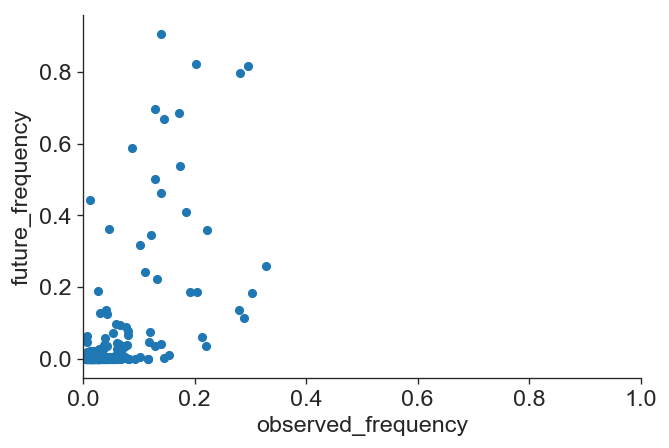

In [12]:
ax = clade_frequencies.plot(
    x="observed_frequency",
    y="future_frequency",
    kind="scatter"
)
ax.set_xlim(0, 1)

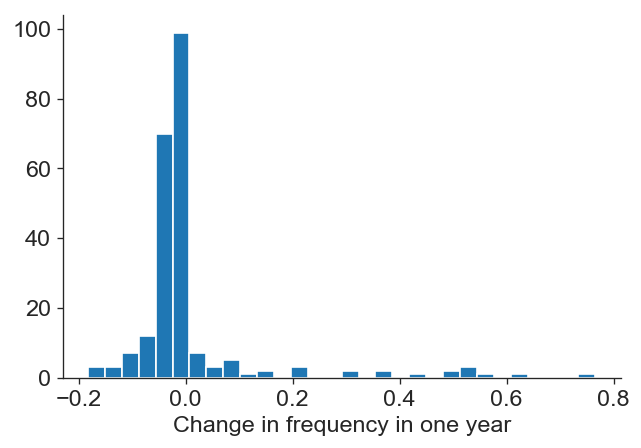

In [13]:
plt.hist(clade_frequencies["future_frequency"] - clade_frequencies["observed_frequency"], bins=30)
plt.xlabel("Change in frequency in one year")

Plot observed frequency fold change by predictors.

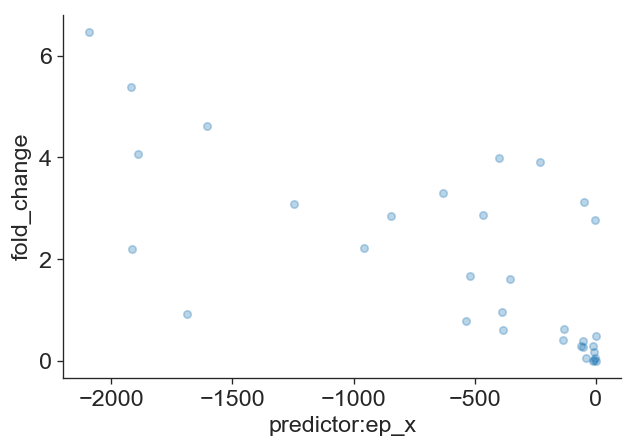

In [29]:
ax = clade_frequencies[clade_frequencies["observed_frequency"] > 0.1].plot(
    x="predictor:ep_x",
    y="fold_change",
    kind="scatter",
    alpha=0.3
)

## Plot frequency trajectories of clades per timepoint

In [15]:
with open("flu_h3n2_ha_2006-2018y_12v_0.json", "r") as fh:
    frequencies = json.load(fh)

In [16]:
pivots = np.array(frequencies["data"]["pivots"])

In [17]:
cmap = plt.get_cmap("tab20")

In [18]:
clade_names = clade_frequencies["clade_name"].unique()
color_by_clade_name = {}
for i, clade_name in enumerate(clade_names):
    color_by_clade_name[clade_name] = cmap(i % 20)

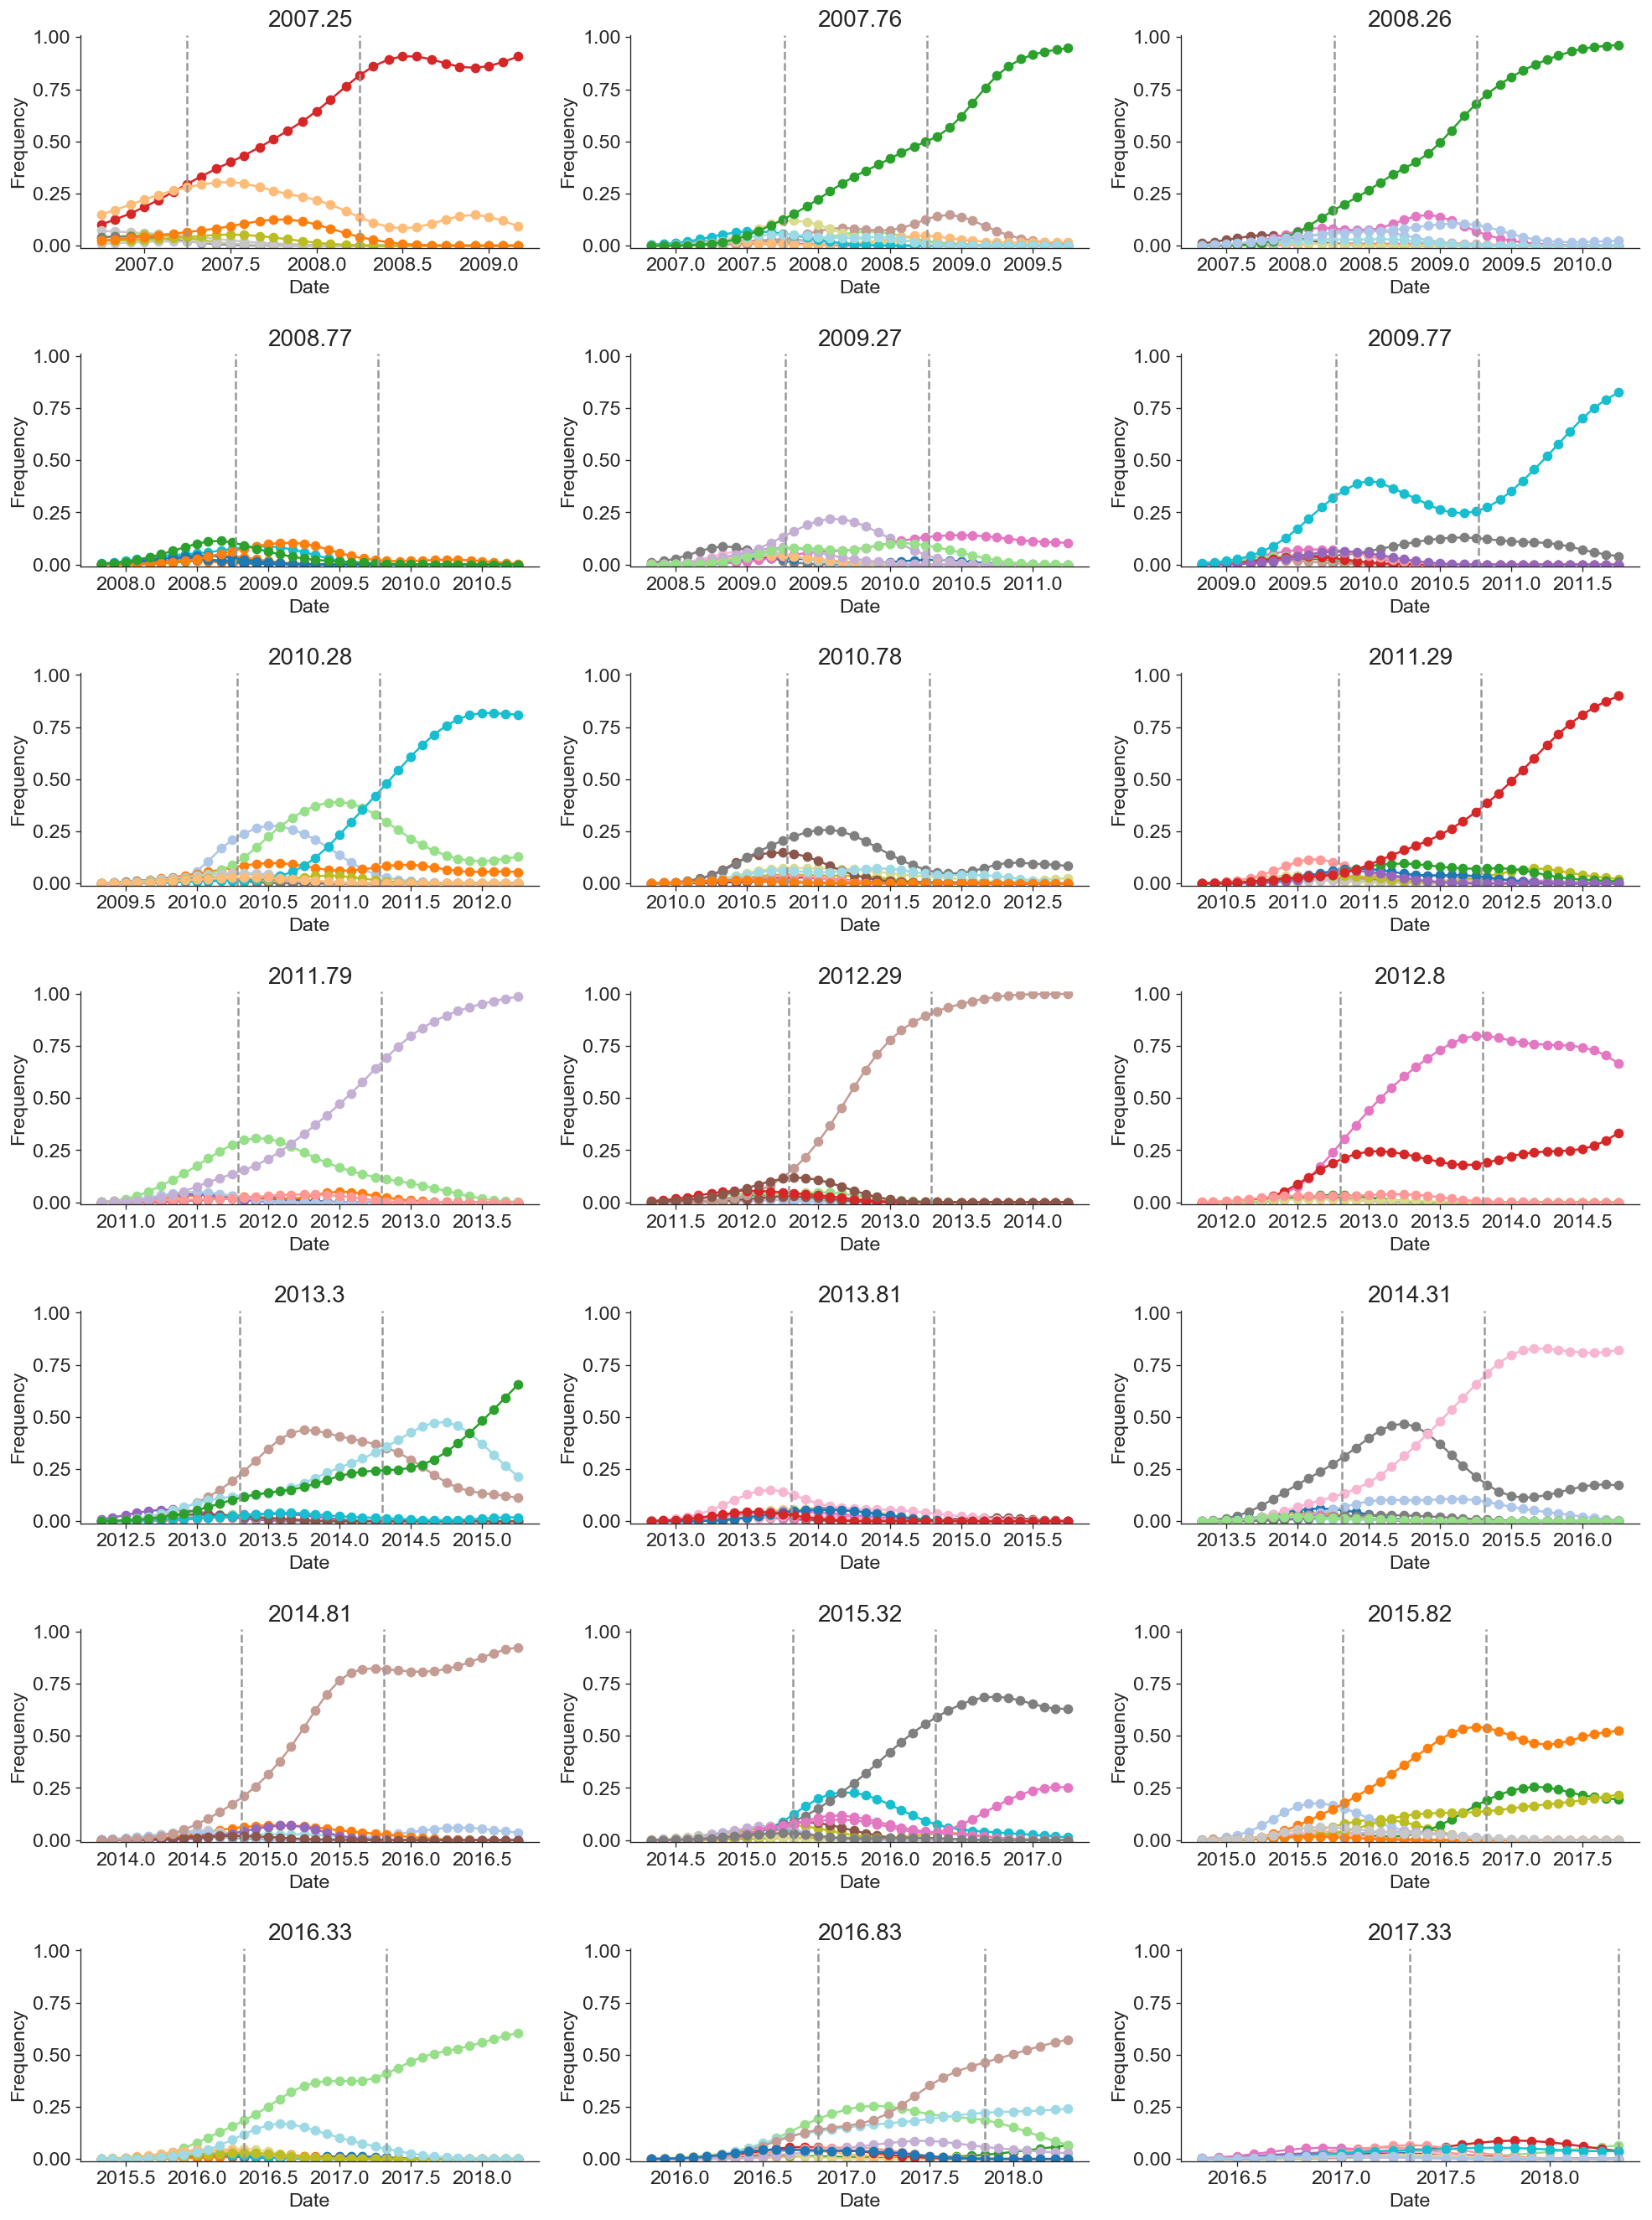

In [19]:
timepoints = sorted(clade_frequencies["timepoint"].unique())
n_cols = 3
n_rows = int(np.ceil(len(timepoints) / float(n_cols)))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), gridspec_kw={"hspace": 0.5})

for i, ax in enumerate(axes.flatten()):
    if i < len(timepoints):
        timepoint = timepoints[i]
        start_pivot_index = pivots.searchsorted(timepoint - 1)
        end_pivot_index = pivots.searchsorted(timepoint + 2)
        
        clade_names = clade_frequencies[clade_frequencies["timepoint"] == timepoint]["clade_name"].unique()
        for clade_name in clade_names:
            ax.plot(pivots[start_pivot_index:end_pivot_index],
                    frequencies["data"]["frequencies"][clade_name][start_pivot_index:end_pivot_index],
                    "-o",
                    c=color_by_clade_name[clade_name])

        ax.set_title(timepoint)
        ax.set_xlabel("Date")
        ax.set_ylabel("Frequency")
        ax.set_ylim(-0.01, 1.01)
        ax.axvline(x=timepoint, linestyle="--", color="#999999")
        ax.axvline(x=timepoint + delta_t, linestyle="--", color="#999999")